In [1]:
# importing important stuff

import torch
import torch.nn as nn
import numpy

# defining the discriminator

class Discriminator_block(nn.Module):
    def __init__(self, input_size, features):
        super(Discriminator_block, self).__init__()
        self.conv1 = nn.Sequential(
            # 64*64
                
            nn.Conv2d(input_size, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(.2),
            # 32*32
            
            self.batchnorm(features, features*2, 4, 2, 1),
            # 16*16
            
            self.batchnorm(features*2, features*4, 4, 2, 1),
            # 8*8
            
            self.batchnorm(features*4, features*8, 4, 2, 1),
            # 4*4

            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    # Layers with batch normalization 
    def batchnorm(self, input, out, kernel_size, stride, padding):
        return nn.Sequential(
                    nn.Conv2d(input,out,kernel_size,stride,padding,bias=False),
                    nn.BatchNorm2d(out),
                    nn.LeakyReLU(.2),
                )

    # forward function cause we have to have one 
    def forward(self, x):
        x = self.conv1(x)
        return x

In [2]:

# generator for the GAN
 
class Generator_block(nn.Module):
    def __init__(self, noise,channels,features):
        super(Generator_block, self).__init__()
        
        self.conv2 = nn.Sequential(
                    self.batchnorm(noise, features*16, 4, 1, 0), #4*4
                    self.batchnorm(features*16, features*8, 4, 2, 1), #8*8
                    self.batchnorm(features*8, features*4, 4, 2, 1), #16*16
                    self.batchnorm(features*4, features*2, 4, 2,1), #32*32
                    nn.ConvTranspose2d(features*2, channels, kernel_size=4, stride=2, padding=1),
                    nn.Tanh(),

                )

    # function for batch nomralization
    def batchnorm(self, input, output, kernel_size, stride, padding):
        return nn.Sequential(
                    nn.ConvTranspose2d(input, output, kernel_size, stride, padding, bias=False),
                    nn.BatchNorm2d(output),
                    nn.ReLU(),
                )
    
    # forward function 
    def forward(self, x):
        x = self.conv2(x)
        return x

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
 
import pickle
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import trange
import matplotlib.pyplot as plt
import torchvision.utils as vutils


from discriminator import Discriminator_block
from generator import Generator_block

def initialize_weight(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)

def image_show():
    for _,(a,_) in enumerate(dataset_loader):
        plt.imshow(a[0][0])
        plt.show()
        break

transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],
                             std=[0.229])
])

batch_size=32

dataset = datasets.MNIST(root='../datatest//',transform=transform,download=True)
dataset_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size, shuffle=True,)



c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\torchvision\transforms\transforms.py:840: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [4]:

max_epoch = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-3
NOISE = 100
CHANNELS = 1
FEATURES = 64


G = Generator_block(NOISE, CHANNELS, FEATURES).to(device)
D = Discriminator_block(CHANNELS, FEATURES).to(device)

initialize_weight(G)
initialize_weight(D)

optim_G = optim.Adam(G.parameters(), lr = LEARNING_RATE, betas=(.5, 0.999))
optim_D = optim.Adam(D.parameters(), lr = LEARNING_RATE, betas=(.5, 0.999))
loss_function = nn.BCELoss()

G.train()
D.train()

D_labels = torch.ones([batch_size,1]).to(device)
D_fakes = torch.zeros([batch_size,1]).to(device)
D_losses = []
G_losses = []
img_list = []


In [5]:

for epoch in (wal := trange(max_epoch)):
    for step,(images,_) in enumerate(dataset_loader):
        x = images.to(device)
        x_output = D(x).reshape(-1)
        D_x_loss = loss_function(x_output, torch.ones_like(x_output).to(device))

        z = torch.randn(batch_size, NOISE,1,1).to(device)
        z_output = D(G(z)).reshape(-1)
        D_z_loss = loss_function(z_output, torch.zeros_like(z_output).to(device))
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        optim_D.step()

        z = torch.randn(batch_size, NOISE,1,1).to(device)
        z_output = D(G(z)).reshape(-1)
        G_loss = loss_function(z_output, torch.ones_like(z_output).to(device))

        G.zero_grad()
        G_loss.backward()
        optim_G.step()

        wal.set_description(f'Step: {step}, D Loss: {D_loss.item()}, G Loss: {G_loss.item()}')
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if step % 20 == 0:
            with torch.no_grad():
                fake = G(z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        step += 1
        if step == 100:
            break

Step: 99, D Loss: 0.000773558858782053, G Loss: 8.092874526977539: 100%|████████████████| 1/1 [01:41<00:00, 101.77s/it]


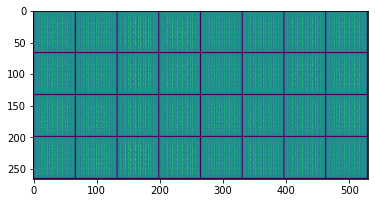

In [8]:
plt.imshow(img_list[0][0])

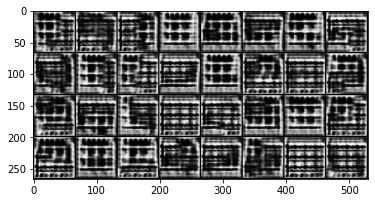

In [11]:
plt.imshow(img_list[-1][0],cmap='gray')

In [7]:
img_list[0][0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4958,  ..., 0.4807, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4855,  ..., 0.4782, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])